In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear Model

Train a linear model for a single dayofyear using one of the ml datasets we made.

In [181]:
import dask.distributed
import logging
import matplotlib.pyplot as plt
import pathlib
import torch
import torch.nn as nn
import xarray as xr

In [45]:
from crims2s.util import add_biweekly_dim

In [46]:
ML_DATASET = '***BASEDIR***/mlready/2021-07-25-test'

In [47]:
ml_dataset_path = pathlib.Path(ML_DATASET)
ml_files = [x for x in ml_dataset_path.iterdir() if x.name.endswith('0102.nc')]

In [48]:
ml_files

[PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20000102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20010102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20020102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20030102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20040102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20050102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20060102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20070102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20080102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20090102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20100102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/train_example_20110102.nc'),
 PosixPath('***BASEDIR***/mlready/2021-07-25-test/tr

In [49]:
def apply_to_all(transform, example):
    """Utility function to apply a transform on all the kews of an example."""
    new_example = {}
    for k in example:
        new_example[k] = transform(example[k])
    
    return new_example

In [50]:
def add_biweekly_dim_transform(example):
    return apply_to_all(add_biweekly_dim, example)

In [97]:
def rename_to_lead_time(dataset):
    return dataset.rename_dims({'biweekly_forecast': 'lead_time'}).assign_coords(lead_time=dataset.biweekly_forecast.data)

In [124]:
def aggregate_weekly(example):
    obs = example['obs']
    aggregate_obs_tp = obs.pr.sum(dim='lead_time', skipna=True).rename('tp')
    aggregate_obs_t2m = obs.t2m.mean(dim='lead_time', skipna=True)
    new_obs = xr.merge([aggregate_obs_tp, aggregate_obs_t2m])
    
    model = example['model']
    aggregate_model_tp = model.tp.isel(lead_time=-1)
    aggregate_model_t2m = model.t2m.mean(dim='lead_time', skipna=True)
    new_model = xr.merge([aggregate_model_tp, aggregate_model_t2m])
        
    new_features = example['features'].mean(dim='lead_time')
    
    return {
        'obs': rename_to_lead_time(new_obs),
        'features': new_features,
        'model': rename_to_lead_time(new_model.drop('lead_time'))
    }

In [138]:
def s2s_to_pytorch(example):
    obs = example['obs']
    model = example['model']
    features = example['features']
    
    return {
        'obs_t2m': torch.from_numpy(obs.t2m.data),
        'obs_tp': torch.from_numpy(obs.tp.data),
        'features': torch.from_numpy(features.x.data),
        'model_t2m': torch.from_numpy(model.t2m.data),
        'model_tp': torch.from_numpy(model.tp.data),
    }

In [126]:
class CompositeTransform:
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, example):
        transformed_example = example
        for t in self.transforms:
            transformed_example = t(transformed_example)
            
        return transformed_example

In [127]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.transform(self.dataset[idx])

In [128]:
class S2SDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, filter_str=None):
        dataset_path = pathlib.Path(dataset_dir)
        self.files = [x for x in dataset_path.iterdir() if filter_str is None or filter_str in x.name]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        f = self.files[idx]
        features = xr.open_dataset(f, group='/x')
        obs = xr.open_dataset(f, group='/obs')
        model = xr.open_dataset(f, group='/model')
        
        return {'features': features, 'obs': obs, 'model': model}

In [129]:
dataset = S2SDataset(ML_DATASET, filter_str='0102.nc')

In [130]:
dataset[0]

{'features': <xarray.Dataset>
 Dimensions:             (latitude: 121, lead_time: 46, longitude: 240, realization: 11, variable: 13)
 Coordinates:
   * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
   * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
     forecast_time       datetime64[ns] ...
   * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
   * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
     valid_time          (lead_time) datetime64[ns] ...
     forecast_dayofyear  int64 ...
     forecast_year       int64 ...
   * variable            (variable) object 'lsm' 'msl' 'siconc' ... 'v200' 'v850'
 Data variables:
     x                   (lead_time, latitude, longitude, realization, variable) float32 ...,
 'obs': <xarray.Dataset>
 Dimensions:             (latitude: 121, lead_time: 46, longitude: 240)
 Coordinates:
     time                (lead_time) datetime64[ns] ...
   * latitude   

In [131]:
transformed = add_biweekly_dim_transform(dataset[0])

In [132]:
transformed = aggregate_weekly(add_biweekly_dim_transform(dataset[0]))

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 2, latitude: 121, longitude: 240, realization: 11)
Coordinates:
    lead_time           timedelta64[ns] 13 days
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       datetime64[ns] 2000-01-02
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (biweekly_forecast) datetime64[ns] 2000-01-29 2000-02-12
    forecast_dayofyear  int64 2
    forecast_year       int64 2000
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 14 days 28 days
Data variables:
    tp                  (biweekly_forecast, latitude, longitude, realization) float32 ...
    t2m                 (biweekly_forecast, latitude, longitude, realization) float32 ...


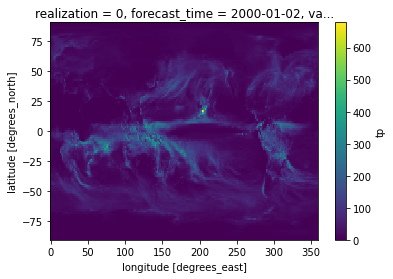

In [137]:
transformed['model'].isel(lead_time=1, realization=0).tp.plot()

In [ ]:
transformed['obs'].t2m.isel(lead_time=0).plot()

In [139]:
s2s_to_pytorch(transformed)

{'obs_t2m': tensor([[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],
 
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]),
 'obs_tp': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 3.9921, 3.8992,  ..., 4.3174, 4.2413, 4.1620],
          [0.0000, 2.3551, 2.3059,  ..., 2.5403, 2.4962, 2.4505],
          [0.0000, 0.0

In [147]:
transform = CompositeTransform([add_biweekly_dim_transform, aggregate_weekly, s2s_to_pytorch])
dataset = TransformedDataset(S2SDataset(ML_DATASET, filter_str='0102.nc'), transform)

In [152]:
dataset[0]['obs_tp'].shape

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 2, latitude: 121, longitude: 240, realization: 11)
Coordinates:
    lead_time           timedelta64[ns] 13 days
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       datetime64[ns] 2000-01-02
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (biweekly_forecast) datetime64[ns] 2000-01-29 2000-02-12
    forecast_dayofyear  int64 2
    forecast_year       int64 2000
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 14 days 28 days
Data variables:
    tp                  (biweekly_forecast, latitude, longitude, realization) float32 ...
    t2m                 (biweekly_forecast, latitude, longitude, realization) float32 ...


torch.Size([2, 121, 240])

In [153]:
example = dataset[3]

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 2, latitude: 121, longitude: 240, realization: 11)
Coordinates:
    lead_time           timedelta64[ns] 13 days
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       datetime64[ns] 2003-01-02
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (biweekly_forecast) datetime64[ns] 2003-01-29 2003-02-12
    forecast_dayofyear  int64 2
    forecast_year       int64 2003
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 14 days 28 days
Data variables:
    tp                  (biweekly_forecast, latitude, longitude, realization) float32 ...
    t2m                 (biweekly_forecast, latitude, longitude, realization) float32 ...


In [156]:
example['features'].shape

torch.Size([2, 121, 240, 11, 13])

In [159]:
example['obs_t2m'].shape

torch.Size([2, 121, 240])

In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        t2m_mu_weights = nn.Parameter(torch.rand(2, 121, 240, 11, 13))
        t2m_mu_bias = nn.Parameter(torch.rand(2, 121, 240))
        
        t2m_sigma_weights = nn.Parameter(torch.rand(2, 121, 240, 11, 13))
        t2m_sigma_bias = nn.Parameter(torch.rand(2, 121, 240))

        
    def forward(self, example):
        

In [170]:
t2m_weights = torch.rand(2, 121, 240, 11, 13, requires_grad=True)

In [171]:
t2m_correction = torch.einsum('wijmv,wijmv->wij', example['features'], weights)

In [172]:
t2m_bias = torch.rand(2, 121, 240, requires_grad=True)

In [184]:
example['model_t2m'].shape

torch.Size([2, 121, 240, 11])

In [182]:
pred = example['model_t2m'] + t2m_correction + t2m_bias 

RuntimeError: The size of tensor a (11) must match the size of tensor b (240) at non-singleton dimension 3

In [174]:
pred

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<AddBackward0>)

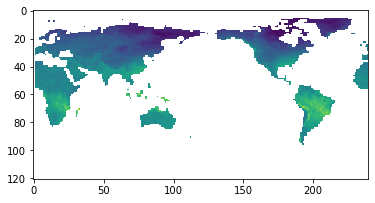

In [179]:
plt.imshow(pred.detach().numpy()[1])

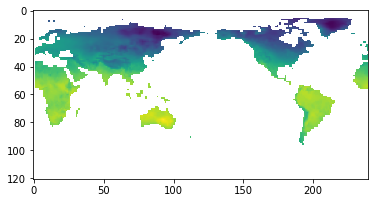

In [180]:
plt.imshow(example['obs_t2m'][0])